PSF Heatmap Analysis
===================

This module provides functionality to analyze and visualize Point Spread Function (PSF) 
measurements from microscopy data. It processes FWHM (Full Width at Half Maximum) ratio 
and lateral asymmetry measurements to create interpolated heatmaps showing PSF quality 
variations across the field of view.

Requirements:
------------
- numpy
- matplotlib
- dataclasses

The input data should be organized as follows:

```
root_directory/
    ├── PSFData/
    │   └── 63X_1_4_525/
    │       ├── 63X_1_4_525_data/
    │       ├── Image 1/
    │       │   ├── bead1/
    │       │   └── bead2/
    │       └── Image 2/
    │           ├── bead1/
    │           └── bead2/
```

Each bead folder should contain XLS files with PSF measurements from MetroloJ. 


## Importing and Installing Modules

In [1]:
!pip3 install numpy
!pip3 install matplotlib
!pip3 install dataclasses

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
import re
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

## Default Values

In [3]:
DEFAULT_MAIN_DIR = "PSFData"
DEFAULT_IMAGES_DIR = "63X_1_4_525"
DEFAULT_INTERPOLATION_POWER = 2
DEFAULT_RESOLUTION = 100
DEFAULT_MIN_POINTS = 5
DEFAULT_COLORMAP = ["darkblue", "lightblue", "lightgreen", "orange", "red"]
DEFAULT_VMIN = 0
DEFAULT_VMAX = 2

## Data Extraction and Analysis Functions

### Bead Data Class

In [4]:
@dataclass
class BeadData:
    """
    Data structure to hold PSF measurements for a single bead.
    
    Attributes:
        image (str): Image identifier
        bead (str): Bead identifier
        mes_theory_ratio (Dict[str, float]): FWHM ratios for X, Y, Z dimensions
        fit_goodness (Dict[str, str]): Fit quality indicators
        lateral_asymmetry (float): Measure of PSF symmetry in XY plane
        coordinates (Dict[str, float]): X, Y positions of the bead
        validity (Dict[str, str]): Validity status for each dimension
    """
    image: str
    bead: str
    mes_theory_ratio: Dict[str, float]
    fit_goodness: Dict[str, str]
    lateral_asymmetry: float
    coordinates: Dict[str, float]
    validity: Dict[str, str]

### Data Extraction and Processing

In [5]:
def process_bead_data(main_directory=DEFAULT_MAIN_DIR, 
                     images_directory=DEFAULT_IMAGES_DIR) -> List[Dict]:
    """
    Process PSF measurement data from all beads in the specified directory.
    
    Args:
        main_directory (str): Root directory containing PSF data
        images_directory (str): Subdirectory for specific microscope configuration
    
    Returns:
        List[Dict]: List of dictionaries containing processed bead data
        
    Raises:
        FileNotFoundError: If specified directory doesn't exist
    """
    psf_path = os.path.join(main_directory, images_directory)

    if not os.path.exists(psf_path):
        raise FileNotFoundError(f"Directory not found: {psf_path}")

    # Get validity status for all beads
    status_data = parse_status(main_directory, images_directory)

    # Get all image folders
    items = os.listdir(psf_path)
    image_folders = [
        item for item in items
        if os.path.isdir(os.path.join(psf_path, item))
        and re.match(r'^Image \d+$', item)
    ]

    beads_list = []

    for image in image_folders:
        image_path = os.path.join(psf_path, image)
        # Get all bead folders
        bead_folders = [
            item for item in os.listdir(image_path)
            if os.path.isdir(os.path.join(image_path, item))
            and re.match(r'^bead\d+$', item)
        ]

        for bead in bead_folders:
            data_folder = f"{images_directory}_{image}_{bead}_data"
            file_path = os.path.join(image_path, bead, data_folder)
            xls_file_path = os.path.join(file_path, f"{images_directory}_{image}_{bead}_results.xls")

            # Get validity status for this bead
            status_key = f"{image}_{bead}".replace(" ", "")
            validity_status = status_data.get(status_key, {
                'X': 'unknown',
                'Y': 'unknown',
                'Z': 'unknown'
            })

            try:
                bead_data = parse_bead(xls_file_path, image, bead, validity_status)
                if bead_data:
                    beads_list.append(bead_data)
            except FileNotFoundError:
                print(f"\nError: {xls_file_path} not found")
            except Exception as e:
                print(f"\nError processing {xls_file_path}: {str(e)}")

    return beads_list

def parse_coordinates(coord_str):
    """Parse coordinate string into x, y values."""
    try:
        x, y = map(float, coord_str.split(', '))
        return x, y
    except ValueError:
        raise ValueError(f"Invalid coordinate format: {coord_str}")

def is_numeric(value):
    """Check if a string can be converted to a float."""
    try:
        float(value)
        return True
    except (ValueError, TypeError):
        return False

def parse_status(main_directory=DEFAULT_MAIN_DIR, images_directory=DEFAULT_IMAGES_DIR):
    """Parse status data from BatchRawData.xls file."""
    file_path = os.path.join(main_directory, images_directory,
                            f"{images_directory}_data",
                            f"{images_directory}_BatchRawData.xls")

    try:
        with open(file_path, 'r') as file:
            data = file.read().split("\n")

            # Get the data rows
            bead_ids = data[13].split("\t")[2:]
            x_status = data[16].split("\t")[2:]
            y_status = data[25].split("\t")[2:]
            z_status = data[34].split("\t")[2:]

            # Create dictionary with X, Y, Z status for each bead
            status = {}
            for bead_id, x, y, z in zip(bead_ids, x_status, y_status, z_status):
                status[bead_id] = {
                    'X': x,
                    'Y': y,
                    'Z': z
                }
            return status
    except FileNotFoundError:
        print(f"\nError: Status file not found: {file_path}")
        return {}
    except Exception as e:
        print(f"\nError parsing status file: {str(e)}")
        return {}

def parse_bead(file_path, image, bead, validity_status):
    """Parse individual XLS file containing bead measurements."""
    with open(file_path, 'r') as file:
        data = file.read()

        result = {
            "Image": image,
            "Bead": bead,
            "Mes./theory ratio": {},
            "Fit Goodness": {},
            "Lateral Asymmetry": None,
            "Bead coordinates (pixels)": {},
            "Validity": validity_status
        }

        lines = data.split('\n')
        resolution_table_start = False
        lateral_asymmetry_table_start = False

        for line in lines:
            if "Bead original coordinates(in pixels)" in line:
                coords = line.split('\t')[2].strip()
                if coords:
                    try:
                        x, y = parse_coordinates(coords)
                        result["Bead coordinates (pixels)"].update({"X": x, "Y": y})
                    except ValueError:
                        print(f"Invalid coordinates for {image}/{bead}")

            elif "Resolution" in line:
                resolution_table_start = True
                continue

            elif resolution_table_start and line.strip() and line.split("\t")[0] != "Channel":
                parts = line.split('\t')
                if len(parts) >= 7:
                    process_resolution_line(parts, result)

            if line.strip().startswith("Lateral Asymmetry"):
                lateral_asymmetry_table_start = True

                continue

            if lateral_asymmetry_table_start and line.strip().startswith("Channel 0"):
                process_asymmetry_line(line, result)
                break

        return result

def process_resolution_line(parts, result):
    """Process a line from the resolution table."""
    dimension = parts[2]
    ratio = parts[6]
    fit_goodness = parts[5]
    if is_numeric(ratio):
        ratio_value = float(ratio)
        result["Fit Goodness"][dimension] = fit_goodness
        result["Mes./theory ratio"][dimension] = ratio_value

def process_asymmetry_line(line, result):
    """Process a line containing lateral asymmetry data."""
    parts = line.split('\t')
    if len(parts) >= 2:
        asymmetry = parts[1]
        if is_numeric(asymmetry):
            result["Lateral Asymmetry"] = float(asymmetry)


def filter_valid_beads(beads_list):
    """Remove beads with invalid measurements."""
    valid_beads = []

    for bead in beads_list:
        validity = bead["Validity"]
        # Check if all dimensions are valid (not 'NO' or 'unknown')
        if (validity['X'] == 'valid' and
            validity['Y'] == 'valid' and
            validity['Z'] == 'valid'):
            valid_beads.append(bead)

    return valid_beads

### IDW Interpolation 

In [6]:
def idw(x: np.ndarray, y: np.ndarray, z: np.ndarray, 
        xi: np.ndarray, yi: np.ndarray, 
        power: float = 2, 
        search_radius: Optional[float] = None,
        min_points: int = 5) -> np.ndarray:
    """
    Perform Inverse Distance Weighted (IDW) interpolation with adaptive search radius.
    
    Args:
        x, y: Coordinates of known data points
        z: Values at known points
        xi, yi: Grid points where interpolation is needed
        power: Distance power parameter (higher values increase local influence)
        search_radius: Maximum distance to consider for interpolation
        min_points: Minimum number of points to use for interpolation
    
    Returns:
        np.ndarray: Interpolated values at grid points
    """
    zi = np.zeros_like(xi)

    # Calculate the default search radius if none provided
    if search_radius is None:
        x_range = np.max(x) - np.min(x)
        y_range = np.max(y) - np.min(y)
        search_radius = np.sqrt(x_range**2 + y_range**2) / 4

    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            dists = np.sqrt((x - xi[i, j])**2 + (y - yi[i, j])**2)

            # Apply search radius
            if search_radius:
                mask = dists <= search_radius
                if np.sum(mask) >= min_points:
                    dists = dists[mask]
                    local_z = z[mask]
                else:
                    # If not enough points within radius, use nearest points
                    nearest_indices = np.argsort(dists)[:min_points]
                    dists = dists[nearest_indices]
                    local_z = z[nearest_indices]
            else:
                local_z = z

            # Avoid division by zero
            dists[dists < 1e-10] = 1e-10

            # Calculate weights
            weights = 1 / dists**power

            # Normalize weights
            weights /= np.sum(weights)

            # Calculate interpolated value
            zi[i, j] = np.sum(weights * local_z)

    return zi


### Plotting Heatmap

In [10]:
def plot_psf_heatmaps(complete_beads: List[Dict], 
                     incomplete_beads: Optional[List[Dict]] = None,
                     vmin: float = DEFAULT_VMIN,
                     vmax: float = DEFAULT_VMAX,
                     cmap: List[str] = DEFAULT_COLORMAP,
                     power: float = DEFAULT_INTERPOLATION_POWER,
                     resolution: int = DEFAULT_RESOLUTION,
                     **kwargs) -> None:
    """
    Generate heatmap visualizations of PSF measurements.
    
    Creates four heatmaps showing:
    - X dimension FWHM ratio
    - Y dimension FWHM ratio
    - Z dimension FWHM ratio
    - Lateral asymmetry
    
    Args:
        complete_beads: List of beads with valid measurements
        incomplete_beads: List of beads with invalid/incomplete measurements
        vmin, vmax: Color scale limits
        cmap: List of colors for the colormap
        power: IDW interpolation power parameter
        resolution: Number of grid points in each dimension
    """
    if incomplete_beads is None:
        incomplete_beads = []

    # Extract data
    x = np.array([bead["Bead coordinates (pixels)"]["X"] for bead in complete_beads])
    y = np.array([bead["Bead coordinates (pixels)"]["Y"] for bead in complete_beads])
    z_x = np.array([bead["Mes./theory ratio"]["X"] for bead in complete_beads])
    z_y = np.array([bead["Mes./theory ratio"]["Y"] for bead in complete_beads])
    z_z = np.array([bead["Mes./theory ratio"]["Z"] for bead in complete_beads])
    z_lat = np.array([bead["Lateral Asymmetry"] for bead in complete_beads])

    # Create meshgrid with adaptive resolution
    xi = np.linspace(min(x), max(x), resolution)
    yi = np.linspace(min(y), max(y), resolution)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate data using improved IDW
    zi_x = idw(x, y, z_x, xi, yi, power=power, search_radius=None)
    zi_y = idw(x, y, z_y, xi, yi, power=power, search_radius=None)
    zi_z = idw(x, y, z_z, xi, yi, power=power, search_radius=None)
    zi_lat = idw(x, y, z_lat, xi, yi, power=power, search_radius=None)

    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    # Define common colormap settings
    all_values = np.concatenate([z_x, z_y, z_z, z_lat])
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", cmap)


    def plot_heatmap(ax, zi, title, z_values):
        im = ax.imshow(zi, extent=[min(x), max(x), max(y), min(y)],
                      origin='upper', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')

        # Plot valid data points
        ax.scatter(x, y, c='red', s=30, label='Valid data', alpha=0.6)

        # Plot invalid data points
        if incomplete_beads:
            invalid_x = []
            invalid_y = []
            for bead in incomplete_beads:
                if all(key in bead["Bead coordinates (pixels)"] for key in ["X", "Y"]):
                    invalid_x.append(bead["Bead coordinates (pixels)"]["X"])
                    invalid_y.append(bead["Bead coordinates (pixels)"]["Y"])
            if invalid_x:
                ax.scatter(invalid_x, invalid_y, c='gray', s=20,
                          alpha=0.3, label='Invalid data')

        ax.legend()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    # Plot heatmaps
    plot_heatmap(axs[0, 0], zi_x, 'X FWHM / Theoretical', z_x)
    plot_heatmap(axs[0, 1], zi_y, 'Y FWHM / Theoretical', z_y)
    plot_heatmap(axs[1, 0], zi_z, 'Z FWHM / Theoretical', z_z)
    plot_heatmap(axs[1, 1], zi_lat, 'Lateral Asymmetry', z_lat)

    directory = os.path.join(main_directory,
                            images_directory,
                            f'{images_directory}_data',
                            f'{image_name}.png')

    os.makedirs(os.path.dirname(directory), exist_ok=True)

    plt.tight_layout()
    plt.savefig(directory,
                dpi=300,
                bbox_inches='tight',
                format='png',
                transparent=False)
    plt.show()
    plt.close()

### Saving CSV file

In [11]:
def save_data_to_csv(data: List[Dict],
                     main_directory: str = DEFAULT_MAIN_DIR,
                     images_directory: str = DEFAULT_IMAGES_DIR,
                     image_name: str = f"{DEFAULT_IMAGES_DIR}_Heatmap_RawData") -> None:
    """
    Save PSF measurement data to a CSV file.
    
    Args:
        data (List[Dict]): List of dictionaries containing bead measurements.
            Each dictionary should contain:
            - Image: Image identifier
            - Bead: Bead identifier
            - Mes./theory ratio: Dict with X, Y, Z FWHM ratios
            - Fit Goodness: Dict with X, Y, Z fit quality indicators
            - Lateral Asymmetry: Float value
            - Bead coordinates (pixels): Dict with X, Y positions
            - Validity: Dict with X, Y, Z validity status
            
        main_directory (str, optional): Root directory for data storage.
            Defaults to DEFAULT_MAIN_DIR.
            
        images_directory (str, optional): Subdirectory for specific microscope configuration.
            Defaults to DEFAULT_IMAGES_DIR.
            
        image_name (str, optional): Base name for the output CSV file.
            Defaults to "{DEFAULT_IMAGES_DIR}_Heatmap_RawData".
    
    Returns:
        None
    
    Creates a CSV file with the following columns:
        - Image: Image identifier
        - Bead: Bead identifier
        - X_ratio, Y_ratio, Z_ratio: FWHM ratios
        - X_fit, Y_fit, Z_fit: Fit quality indicators
        - Lateral_Asymmetry: PSF symmetry measure
        - X_coordinate, Y_coordinate: Bead positions
        - X_validity, Y_validity, Z_validity: Measurement validity status
    
    Example:
        >>> save_data_to_csv(bead_data, main_directory="PSFData", 
                            images_directory="63X_1_4_525")
        # Creates: PSFData/63X_1_4_525/63X_1_4_525_data/63X_1_4_525_Heatmap_RawData.csv
    
    Notes:
        - Creates directory structure if it doesn't exist
        - Overwrites existing CSV file if present
    """
    # Construct the full directory path
    directory = os.path.join(DEFAULT_MAIN_DIR,
                            images_directory,
                            f'{images_directory}_data',
                            f'{image_name}.csv')

    # Create directories if they don't exist
    os.makedirs(os.path.dirname(directory), exist_ok=True)

    # Ensure .csv extension
    csv_filename = os.path.splitext(directory)[0] + '.csv'

    # Define CSV headers
    headers = ['Image', 'Bead', 'X_ratio', 'Y_ratio', 'Z_ratio',
               'X_fit', 'Y_fit', 'Z_fit', 'Lateral_Asymmetry',
               'X_coordinate', 'Y_coordinate',
               'X_validity', 'Y_validity', 'Z_validity']

    # Convert bead data to CSV rows
    csv_data = []
    for bead in data:
        row = [
            bead['Image'],
            bead['Bead'],
            bead['Mes./theory ratio']['X'],
            bead['Mes./theory ratio']['Y'],
            bead['Mes./theory ratio']['Z'],
            bead['Fit Goodness']['X'],
            bead['Fit Goodness']['Y'],
            bead['Fit Goodness']['Z'],
            bead['Lateral Asymmetry'],
            bead['Bead coordinates (pixels)']['X'],
            bead['Bead coordinates (pixels)']['Y'],
            bead['Validity']['X'],
            bead['Validity']['Y'],
            bead['Validity']['Z']
        ]
        csv_data.append(row)

    # Write data to CSV file
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(csv_data)

# PSF Analysis Pipeline Documentation

## Overview

This code sequence represents the main workflow for analyzing Point Spread Function (PSF) measurements from microscopy data. The pipeline processes bead measurements, saves the data, filters valid measurements, and generates visualization heatmaps.

## Pipeline Steps

### 1. Data Processing
```python
beads_list = process_bead_data()
```
Extracts and processes raw PSF measurements from individual bead files, including:
- FWHM (Full Width at Half Maximum) ratios
- Fit quality metrics
- Lateral asymmetry values
- Bead coordinates
- Validity status for each dimension

### 2. Data Export
```python
save_data_to_csv(beads_list)
```
Saves the processed measurements to a CSV file with:
- Individual bead identifiers
- Measurement ratios (X, Y, Z)
- Fit quality indicators
- Position coordinates
- Validity status

### 3. Data Filtering
```python
valid_beads = filter_valid_beads(beads_list)
invalid_beads = [bead for bead in beads_list if bead not in valid_beads]
```
Separates measurements into:
- Valid beads: Measurements valid in all dimensions
- Invalid beads: Measurements with at least one invalid dimension

### 4. Visualization
```python
plot_psf_heatmaps(valid_beads, invalid_beads)
```
Generates heatmap visualizations showing:
- Spatial distribution of PSF measurements
- Quality metrics across the field of view
- Comparison between valid and invalid measurements

NameError: name 'main_directory' is not defined

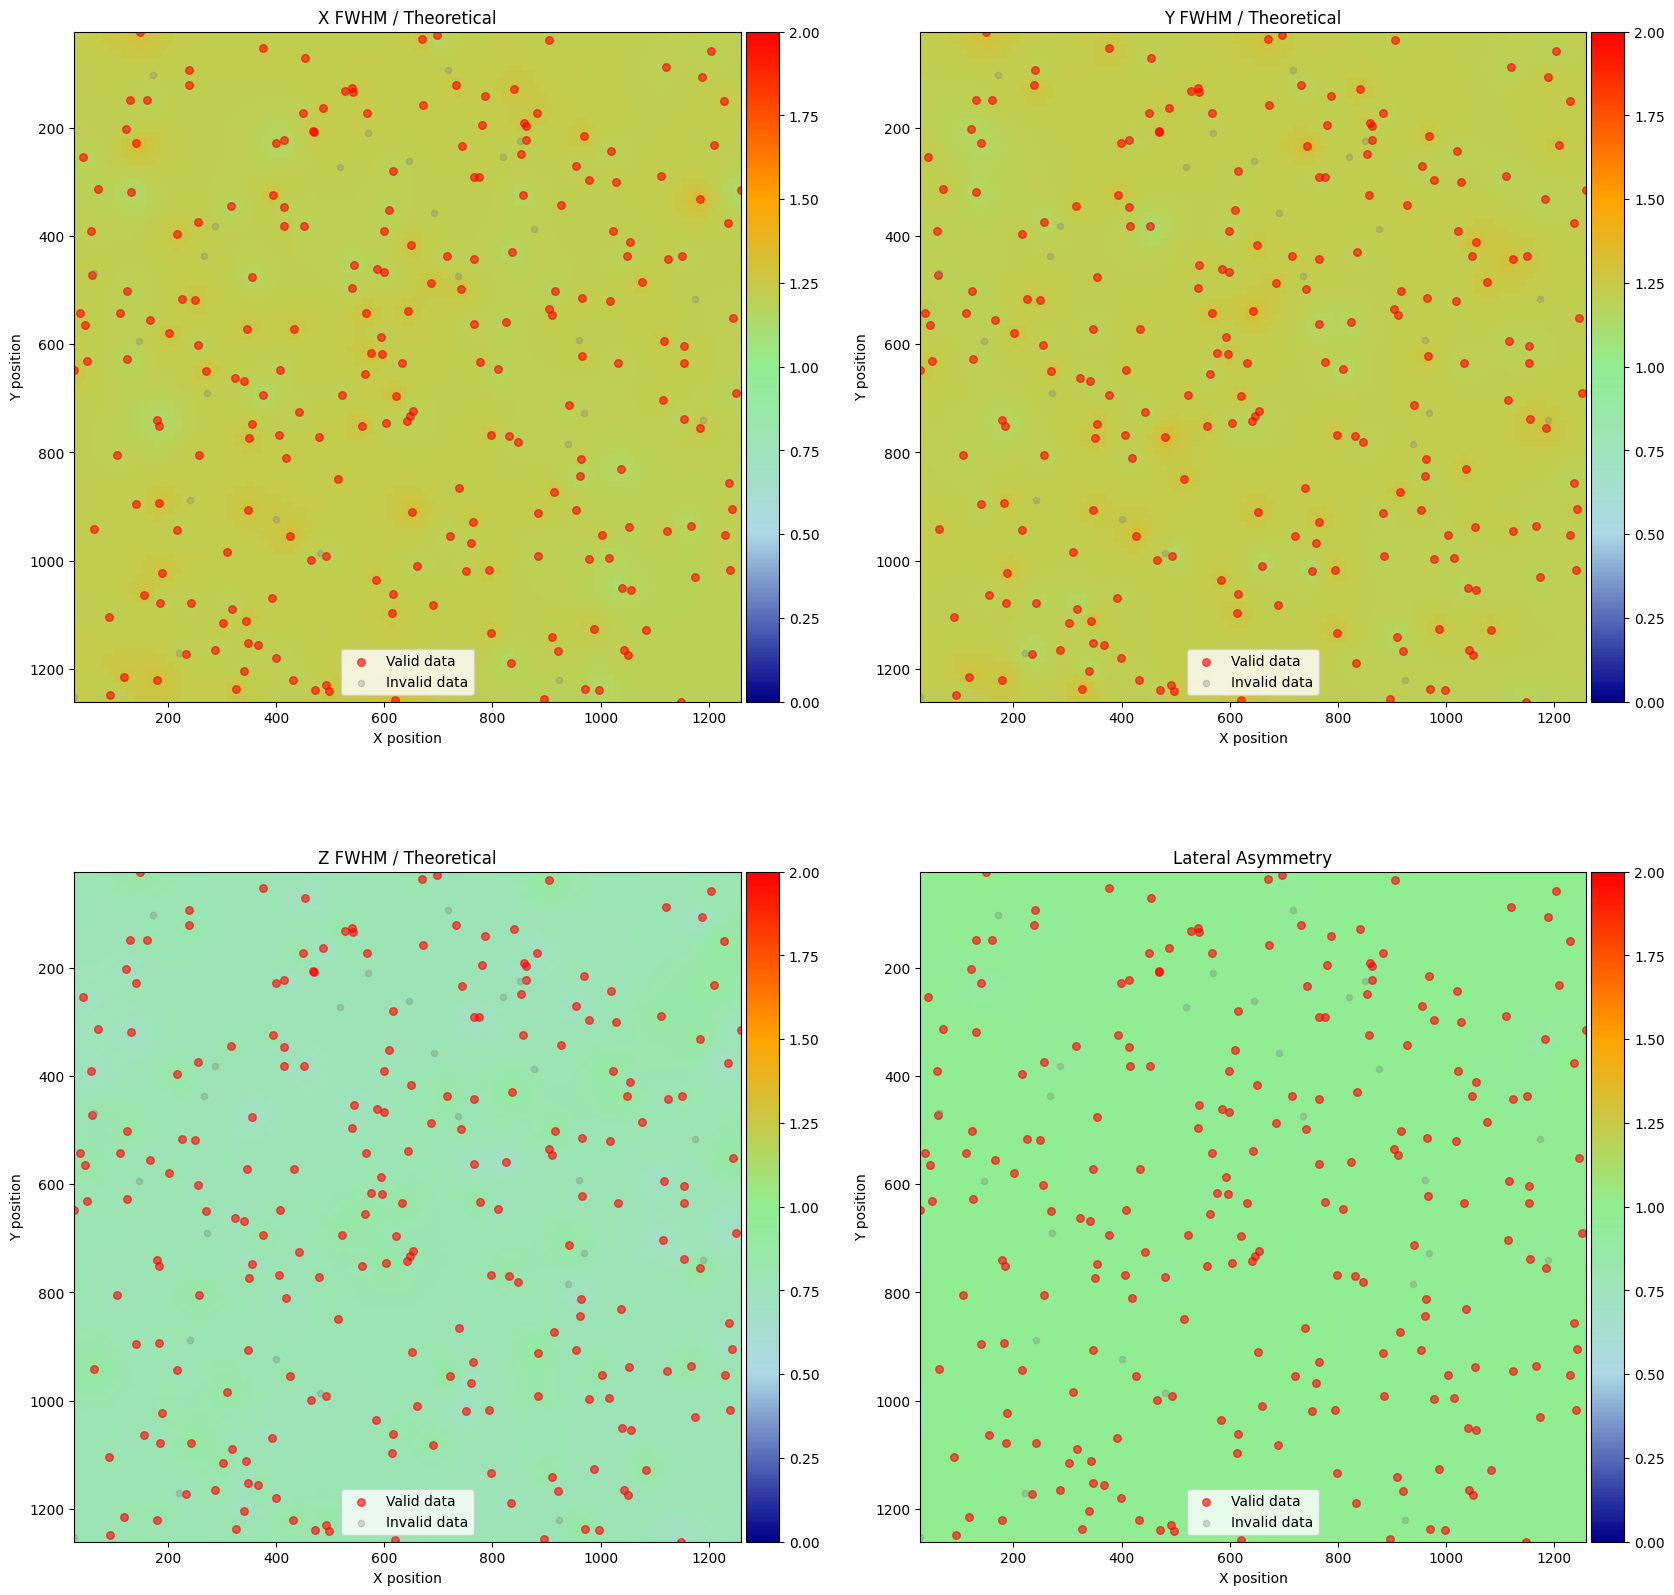

In [12]:
beads_list = process_bead_data()
save_data_to_csv(beads_list)
valid_beads = filter_valid_beads(beads_list)
invalid_beads = [bead for bead in beads_list if bead not in valid_beads]
plot_psf_heatmaps(valid_beads, invalid_beads)